Modern event study plots are the go-to visualization for Difference-in-Differences analysis. But when you overlay results from multiple estimators — Dynamic TWFE, Sun-Abraham, Callaway-Sant'Anna, Imputation DiD — **the coefficients may not mean the same thing**, even if they look the same visually.

Multi-model comparisons can go wrong in several ways. In this post, we focus on three practical questions:

1. **Which estimator should I use?** A quick guide to when each modern DiD estimator is appropriate
2. **How are event study coefficients constructed?** The long vs. short difference distinction, and the "kink" artifact it creates ([Roth, 2026](https://doi.org/10.48550/arXiv.2401.12309))
3. **What about the control group?** Why the choice of never-treated vs. not-yet-treated matters for cross-estimator comparisons

We use the [`diff-diff`](https://github.com/igerber/diff-diff) Python package throughout.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


# Which Estimator When?

Before diving into the technical details, here is a practical guide. Modern DiD offers six main estimators for staggered designs. They differ in how they handle treatment effect heterogeneity, what comparison group they use, and how efficient they are.

## The Landscape

| Estimator | Approach | Handles Heterogeneous Effects? | Efficiency | Best For |
|-----------|----------|-------------------------------|------------|----------|
| **Dynamic TWFE** | Single regression with time dummies | No — biased under heterogeneity | High (if valid) | Simultaneous adoption only |
| **Callaway-Sant'Anna** | 2$\times$2 DiD aggregation | Yes | Moderate | Primary staggered estimator; flexible aggregation |
| **Sun-Abraham** | Interaction-weighted regression | Yes | Moderate | Robustness check alongside CS |
| **Imputation / BJS** | Impute counterfactuals, then aggregate | Yes | **Highest** (~50% shorter CIs) | Preferred when efficiency matters |
| **Two-Stage DiD (Gardner)** | Residualize on untreated, then regress | Yes | **Highest** (same point estimates as BJS) | Alternative to BJS with GMM variance |
| **Synthetic DiD** | Reweight controls to match treated pre-trends | Yes | Varies | Few treated units; questionable parallel trends |

## Decision Tree

**Is treatment adopted at the same time by all units?**

- **Yes** $\rightarrow$ Dynamic TWFE is fine (no staggered-adoption bias). Use `MultiPeriodDiD`.
- **No (staggered)** $\rightarrow$ continue below.

**Do you want the most efficient estimates?**

- **Yes** $\rightarrow$ **Imputation DiD** (or equivalently Two-Stage DiD). These produce the shortest confidence intervals under homogeneous treatment effects. Use as your primary estimator.
- **No / want robustness** $\rightarrow$ continue below.

**Primary analysis or robustness check?**

- **Primary** $\rightarrow$ **Callaway-Sant'Anna**. Most flexible: supports doubly robust estimation, covariates, and multiple aggregation schemes.
- **Robustness** $\rightarrow$ **Sun-Abraham**. If CS and SA agree, results are more credible. If they disagree, investigate heterogeneity.

**Very few treated units or poor parallel trends?**

- **Yes** $\rightarrow$ Consider **Synthetic DiD** or **TROP**. These reweight controls to match the treated unit's pre-treatment trajectory.

## When Results Should Agree

Under parallel trends and *homogeneous* treatment effects, all estimators should produce similar point estimates. When they diverge, it typically signals:

- **Treatment effect heterogeneity** across cohorts or over time
- **Parallel trends violations** (different estimators are more or less sensitive)
- **Different comparison populations** (never-treated vs. not-yet-treated — more on this in @sec-control-group)

# Long vs. Short Differences

Consider a simple 2-group DiD setup with treatment starting at $t=0$ and reference period $t=-1$. Define the group difference at each time $t$:

$$\bar{Y}_t^{D} = \bar{Y}_t^{\text{treat}} - \bar{Y}_t^{\text{control}}$$

Then there are two ways to build event study coefficients:

**Long difference** (relative to a *fixed* reference period):

$$\hat{\beta}_t^{\text{long}} = \bar{Y}_t^D - \bar{Y}_{-1}^D$$

Every period is compared to the **same** baseline ($t=-1$). So $\hat{\beta}_{-5}$ answers: *"how different was the treated-control gap at $t=-5$ compared to $t=-1$?"*

**Short difference** (relative to the *preceding* period):

$$\hat{\beta}_t^{\text{short}} = \bar{Y}_t^D - \bar{Y}_{t-1}^D$$

Each period is compared to its **immediate neighbor**. So $\hat{\beta}_{-5}$ answers: *"how much did the treated-control gap* change *between $t=-6$ and $t=-5$?"*

These are fundamentally different objects. Long differences cumulate deviations from a fixed point; short differences capture incremental changes.

## Numerical Example

Let's make this concrete. Suppose the treated-control gap $\bar{Y}_t^D$ grows linearly in the pre-treatment period, then jumps at $t=0$ due to a treatment effect:

In [2]:
# Concrete example: gap grows linearly, then treatment kicks in
periods = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3])
Y_gap   = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 6.0, 7.0, 8.0, 9.0])

ref = -1
ref_idx = np.where(periods == ref)[0][0]

# Long differences: each period vs fixed reference (t=-1)
beta_long = Y_gap - Y_gap[ref_idx]

# Short differences: each period vs its immediate predecessor
beta_short = np.full(len(periods), np.nan)
for i in range(1, len(periods)):
    beta_short[i] = Y_gap[i] - Y_gap[i-1]

example = pd.DataFrame({
    'period': periods,
    'Y_gap': Y_gap,
    'beta_long (vs t=-1)': beta_long,
    'beta_short (vs t-1)': beta_short,
})
example

,period,Y_gap,beta_long (vs t=-1),beta_short (vs t-1)
0,-5,1.0,-2.0,NaN
1,-4,1.5,-1.5,0.5
2,-3,2.0,-1.0,0.5
3,-2,2.5,-0.5,0.5
4,-1,3.0,0.0,0.5
5,0,6.0,3.0,3.0
6,1,7.0,4.0,1.0
7,2,8.0,5.0,1.0
8,3,9.0,6.0,1.0


Notice the key difference:

- **Long diffs** (pre-treatment): $-2.0, -1.5, -1.0, -0.5, 0$ — a clear downward-to-zero slope revealing the linear pre-trend violation
- **Short diffs** (pre-treatment): $0.5, 0.5, 0.5, 0.5$ — *constant* and seemingly harmless

Both representations contain the same information, but the visual impression is very different. **A linear pre-trend violation is immediately visible with long differences** (the coefficients trend toward the reference), **but hidden with short differences** (the coefficients look flat).

This distinction becomes critical when we mix estimators that use different constructions on the same plot.

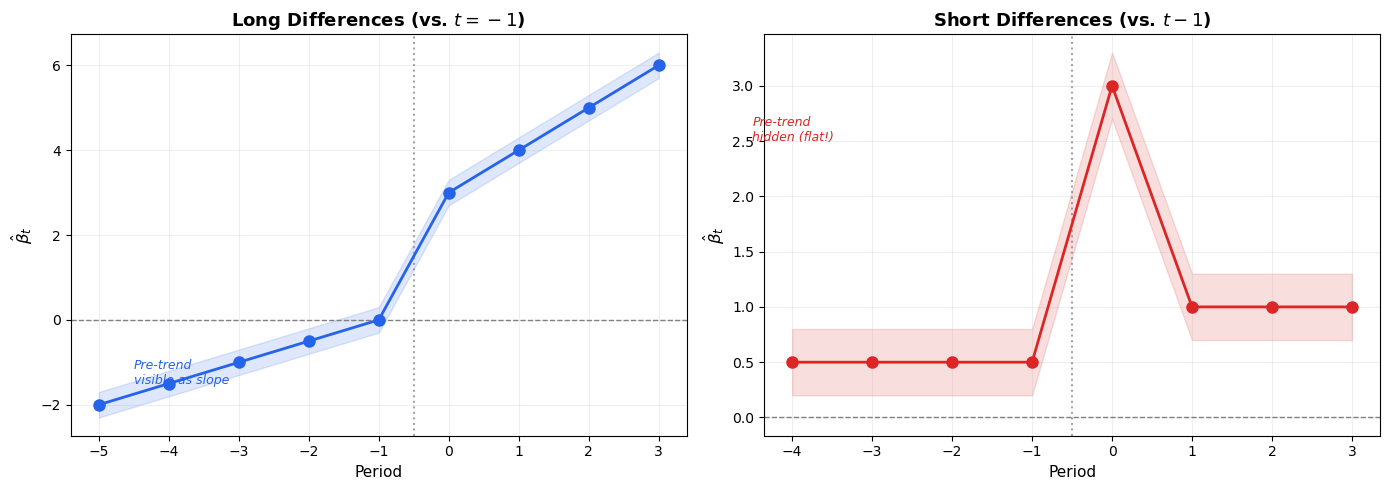

In [3]:
#| label: fig-long-short
#| fig-cap: "Long differences (left) reveal the pre-trend violation as a slope; short differences (right) flatten it into a constant."
#| code-fold: true

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Long differences
ax = axes[0]
ax.plot(periods, beta_long, 'o-', color='#2563eb', markersize=8, linewidth=2, zorder=3)
ax.fill_between(periods, beta_long - 0.3, beta_long + 0.3, alpha=0.15, color='#2563eb')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_title('Long Differences (vs. $t=-1$)', fontsize=13, fontweight='bold')
ax.set_xlabel('Period', fontsize=11)
ax.set_ylabel('$\\hat{\\beta}_t$', fontsize=12)
ax.text(-4.5, -1.5, 'Pre-trend\nvisible as slope', fontsize=9, style='italic', color='#2563eb')
ax.grid(True, alpha=0.2)

# Short differences
ax = axes[1]
ax.plot(periods[1:], beta_short[1:], 'o-', color='#dc2626', markersize=8, linewidth=2, zorder=3)
ax.fill_between(periods[1:], beta_short[1:] - 0.3, beta_short[1:] + 0.3, alpha=0.15, color='#dc2626')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_title('Short Differences (vs. $t-1$)', fontsize=13, fontweight='bold')
ax.set_xlabel('Period', fontsize=11)
ax.set_ylabel('$\\hat{\\beta}_t$', fontsize=12)
ax.text(-4.5, 2.5, 'Pre-trend\nhidden (flat!)', fontsize=9, style='italic', color='#dc2626')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# How Each Estimator Constructs Event Study Coefficients

All modern DiD estimators produce event study coefficients $\hat{\beta}_e$ indexed by relative time $e$ (periods relative to treatment). All normalize $\hat{\beta}_{-1} = 0$ at the reference period. But **how they build the other coefficients differs**.

## Dynamic TWFE

**Reference**: Last pre-period ($e=-1$), dropped from the regression.

**Method**: OLS regression with period dummies:

$$Y_{it} = \alpha_i + \gamma_t + \sum_{e \neq -1} \beta_e \cdot \mathbb{1}[t - g_i = e] + \varepsilon_{it}$$

All $\beta_e$ coefficients (both pre and post) are **long differences** relative to $e=-1$.

Pre-treatment $\hat{\beta}_{-3}$ answers: *"how different was the gap at $e=-3$ vs. $e=-1$?"*

## Sun-Abraham

**Reference**: Also $e=-1$, also dropped from the regression.

**Method**: Same regression structure as Dynamic TWFE, but with **cohort-specific interactions** to handle treatment effect heterogeneity:

$$Y_{it} = \alpha_i + \gamma_t + \sum_{g} \sum_{e \neq -1} \delta_{g,e} \cdot \mathbb{1}[G_i = g] \cdot \mathbb{1}[t - g = e] + \varepsilon_{it}$$

Then aggregates: $\hat{\beta}_e = \sum_g w_{g,e} \cdot \hat{\delta}_{g,e}$ (interaction-weighted average).

All $\beta_e$ are still **long differences** relative to $e=-1$, just with proper heterogeneity handling.

**Bottom line**: Sun-Abraham is TWFE done right. Same reference, same type of coefficient, same interpretation. "Dropping from regression" = normalizing to zero.

## Callaway-Sant'Anna

**Reference**: $e=-1$ (the period before treatment for each cohort $g$).

**Method**: Builds group-time ATTs $\widehat{ATT}(g,t)$ via 2$\times$2 DiD comparisons, then aggregates to an event study.

Here is where it gets tricky: CS has two modes for the **base period**:

### `base_period='universal'`

ALL coefficients (pre and post) use $t = g-1$ as the comparison period:

$$\hat{\beta}_e = \widehat{ATT}(g, g+e) \quad \text{where each ATT compares to } t=g-1$$

This is a **long difference** — same as TWFE / Sun-Abraham. **Comparable: Yes.**

### `base_period='varying'` (the default)

- **Post-treatment**: Uses $t=g-1$ as comparison $\rightarrow$ **long difference**
- **Pre-treatment**: Uses $t-1$ as comparison for each $t$ $\rightarrow$ **short difference**

This means pre- and post-treatment coefficients are constructed with **different formulas**. The pre-treatment coefficients answer a different question than the post-treatment ones.

**Comparable: Only post-treatment.** Pre-treatment coefficients are a fundamentally different quantity.

## Imputation DiD (Borusyak-Jaravel-Spiess) and Two-Stage DiD (Gardner)

This one works completely differently from the others. No regression with period dummies at all.

**Method** (two steps):

1. **Estimate the counterfactual**: Using *only untreated observations* (units before they get treated + never-treated), fit unit and time fixed effects:
$$\hat{Y}_{it}(0) = \hat{\alpha}_i + \hat{\gamma}_t$$
This gives a prediction of what $Y$ would have been *without treatment* for every unit-time.

2. **Compute individual treatment effects**: For each treated observation:
$$\hat{\tau}_{it} = Y_{it} - \hat{Y}_{it}(0) = Y_{it} - \hat{\alpha}_i - \hat{\gamma}_t$$

3. **Aggregate by horizon**: Group the $\hat{\tau}_{it}$ by relative time $h = t - g_i$ and average:
$$\hat{\beta}_h = \frac{1}{N_h} \sum_{i,t: t-g_i = h} \hat{\tau}_{it}$$

**Reference period**: BJS doesn't naturally produce a coefficient at $h=-1$. Since at $h=-1$ no unit is yet treated, there are no $\hat{\tau}_{it}$ to aggregate. The code **manually sets** $\hat{\beta}_{-1} = 0$ for plotting.

**Pre-treatment coefficients** ($h < -1$): These are **placebo tests** — they show $Y - \hat{Y}(0)$ for periods before treatment. If the model is correctly specified, these should be $\approx 0$. They are not "differences relative to a reference period" — they are direct residuals from the counterfactual model.

**Comparable**: Post-treatment **yes** (same estimand: ATT at each relative time). Pre-treatment: similar scale but **different interpretation** (model specification test, not parallel trends relative to a reference).

::: {.callout-note}
## Gardner's Two-Stage DiD
[Gardner (2022)](https://arxiv.org/abs/2207.05943) proposes an equivalent two-step procedure: (1) residualize outcomes using FE estimated on untreated observations, (2) regress residuals on treatment indicators. The **point estimates are identical** to Imputation DiD. The only difference is variance estimation: Gardner uses a GMM sandwich estimator (accounting for first-stage estimation error), while BJS uses a conservative variance (Theorem 3). For event study comparison purposes, they are interchangeable.
:::

# The "Kink" Artifact

Now that we understand the difference between long and short differences, let's see why it matters visually.

Consider a scenario with a **linear pre-trend violation** (the treated-control gap grows by 0.3 each period) but **no treatment effect at all**. The confounding trend continues smoothly through the treatment date — there is no break in the data-generating process.

The question is: **how does each estimator's event study plot represent this smooth, continuous confound?**

[Roth (2026)](https://doi.org/10.48550/arXiv.2401.12309) calls this the "kink" artifact: because CS (varying) uses short differences in the pre-treatment period but long differences in the post-treatment period, the *same* smooth linear confound produces a visual **break** at the treatment date — a kink that looks like a treatment effect, even though the underlying trend is continuous.

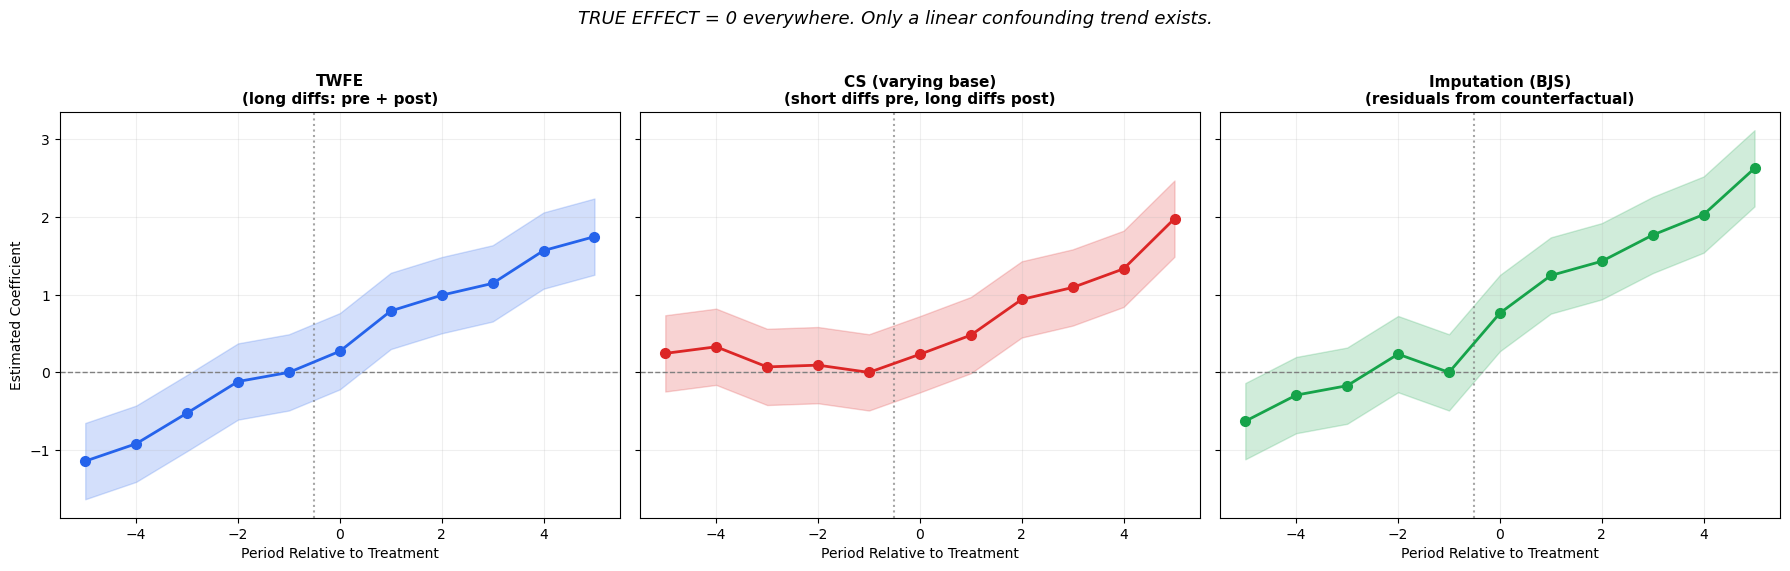

In [4]:
#| label: fig-kink
#| fig-cap: "The kink artifact: with no treatment effect and only a linear confounding trend, all panels show positive post-treatment coefficients (that's the confound, not an effect). The key: TWFE shows a smooth continuous line with no break at the treatment date, while CS (varying) creates an artificial kink."
#| code-fold: true

# Simulate: linear pre-trend violation, NO treatment effect
np.random.seed(42)
periods_sim = np.arange(-5, 6)
ref = -1

# True confounding: gap grows linearly at 0.3 per period
# There is NO treatment effect -- just a trend violation
delta_true = 0.3 * periods_sim
se_sim = np.full(len(periods_sim), 0.25)
noise = lambda: np.random.normal(0, 0.12, len(periods_sim))

# 1. TWFE: ALL coefficients are long diffs vs e=-1
# beta_t = 0.3*t - 0.3*(-1) = 0.3*(t+1)
twfe_coefs = delta_true - delta_true[periods_sim == ref][0] + noise()
twfe_coefs[periods_sim == ref] = 0.0

# 2. CS (varying): pre = SHORT diffs (constant), post = LONG diffs
cs_coefs = np.zeros(len(periods_sim))
for i, p in enumerate(periods_sim):
    if p < ref:
        cs_coefs[i] = 0.3 + np.random.normal(0, 0.12)
    elif p == ref:
        cs_coefs[i] = 0.0
    else:
        cs_coefs[i] = 0.3 * (p - ref) + np.random.normal(0, 0.12)

# 3. Imputation (BJS): residuals from counterfactual model
avg_delta_pre = np.mean(delta_true[periods_sim < 0])
bjs_coefs = delta_true - avg_delta_pre + noise()
bjs_coefs[periods_sim == ref] = 0.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), sharey=True)
colors = ['#2563eb', '#dc2626', '#16a34a']
titles = [
    'TWFE\n(long diffs: pre + post)',
    'CS (varying base)\n(short diffs pre, long diffs post)',
    'Imputation (BJS)\n(residuals from counterfactual)',
]
coefs_list = [twfe_coefs, cs_coefs, bjs_coefs]

for ax, coefs, title, color in zip(axes, coefs_list, titles, colors):
    ax.fill_between(periods_sim, coefs - 1.96*se_sim, coefs + 1.96*se_sim,
                    alpha=0.2, color=color)
    ax.plot(periods_sim, coefs, 'o-', color=color, markersize=7, linewidth=2, zorder=3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(ref + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Period Relative to Treatment')
    if ax == axes[0]:
        ax.set_ylabel('Estimated Coefficient')
    ax.grid(True, alpha=0.2)

fig.suptitle('TRUE EFFECT = 0 everywhere. Only a linear confounding trend exists.',
             fontsize=13, y=1.03, style='italic')
plt.tight_layout()
plt.show()

What you see in @fig-kink — remember, the **true effect is zero** in all three panels; the only thing happening is a linear confounding trend (gap grows by 0.3 per period, continuously through the treatment date):

- **TWFE** (left): A smooth upward line passing through zero at the reference period. The trend is visible both pre- and post-treatment with **no break** at the treatment date. This correctly reveals the confound: "the gap was growing before treatment and kept growing after — there's no discontinuity suggesting a treatment effect."
- **CS (varying)** (center): Flat pre-trends ($\approx 0.3$ each) then a sudden jump post-treatment. This **looks like a treatment effect, but it's entirely an artifact**. Short differences flatten the linear trend into a constant in the pre-period, then the switch to long differences in the post-period creates a visual break. A researcher seeing "flat pre-trends + post-treatment jump" might wrongly conclude that treatment had an effect.
- **BJS** (right): An upward trend both pre- and post-treatment, similar in shape to TWFE but normalized differently (centered around the counterfactual model's average rather than the reference period). No break at the treatment date — correctly showing the continuous confound.

The key visual diagnostic: under a pure linear confound with no treatment, the event study should show a **smooth, continuous line** with no break at $t=0$. TWFE and BJS show this; CS (varying) does not.

# Practical Guide: Which Comparisons Are Fair?

The following table summarizes the coefficient construction and control group of each estimator:

| Estimator | Reference | Pre-treatment | Post-treatment | Control Group | Comparable to TWFE? |
|-----------|-----------|---------------|----------------|---------------|---------------------|
| **Dynamic TWFE** | $e=-1$ (dropped) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | All controls | Baseline |
| **Sun-Abraham** | $e=-1$ (dropped) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | Configurable | **Yes** (match control group) |
| **CS (universal)** | $e=-1$ (fixed) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | Configurable | **Yes** (match control group) |
| **CS (varying)** | $e=-1$ (fixed) | **Short diff** ($e$ vs $e-1$) | Long diff vs. $e=-1$ | Configurable | **Post only** |
| **Imputation / BJS** | $e=-1$ (set to 0) | Placebo residuals | Imputed $\hat{\tau}$ | All untreated obs | **Post yes**, pre: different meaning |
| **Two-Stage DiD** | $e=-1$ (set to 0) | Same as BJS | Same as BJS | All untreated obs | Same as BJS |

## Rules of Thumb

**Safe multi-model overlays:**

- **TWFE + Sun-Abraham + CS (universal)**: Fully comparable, *provided* CS and SA use the same `control_group`. All use long differences relative to the same reference period.
- **Adding Imputation (BJS) or Two-Stage DiD**: Post-treatment coefficients are comparable (same estimand). Pre-treatment coefficients are on a similar scale but have a different interpretation. Note that BJS always uses all untreated observations — closest to `not_yet_treated`.

**Comparisons that require caution:**

- **CS (varying) with any other estimator**: Only post-treatment coefficients are comparable. Pre-treatment coefficients are short differences that will look different from everyone else's long differences.
- **Mismatched control groups**: If one estimator uses `never_treated` and another uses `not_yet_treated`, divergent results may reflect different comparison populations, not estimator disagreement.

**Practical checklist before overlaying event studies:**

1. Set `base_period='universal'` for Callaway-Sant'Anna
2. Match `control_group` across all estimators (CS, SA)
3. Note that BJS/Two-Stage DiD always uses all untreated observations
4. If using CS with `base_period='varying'`, annotate the plot and do not visually compare pre-treatment coefficients

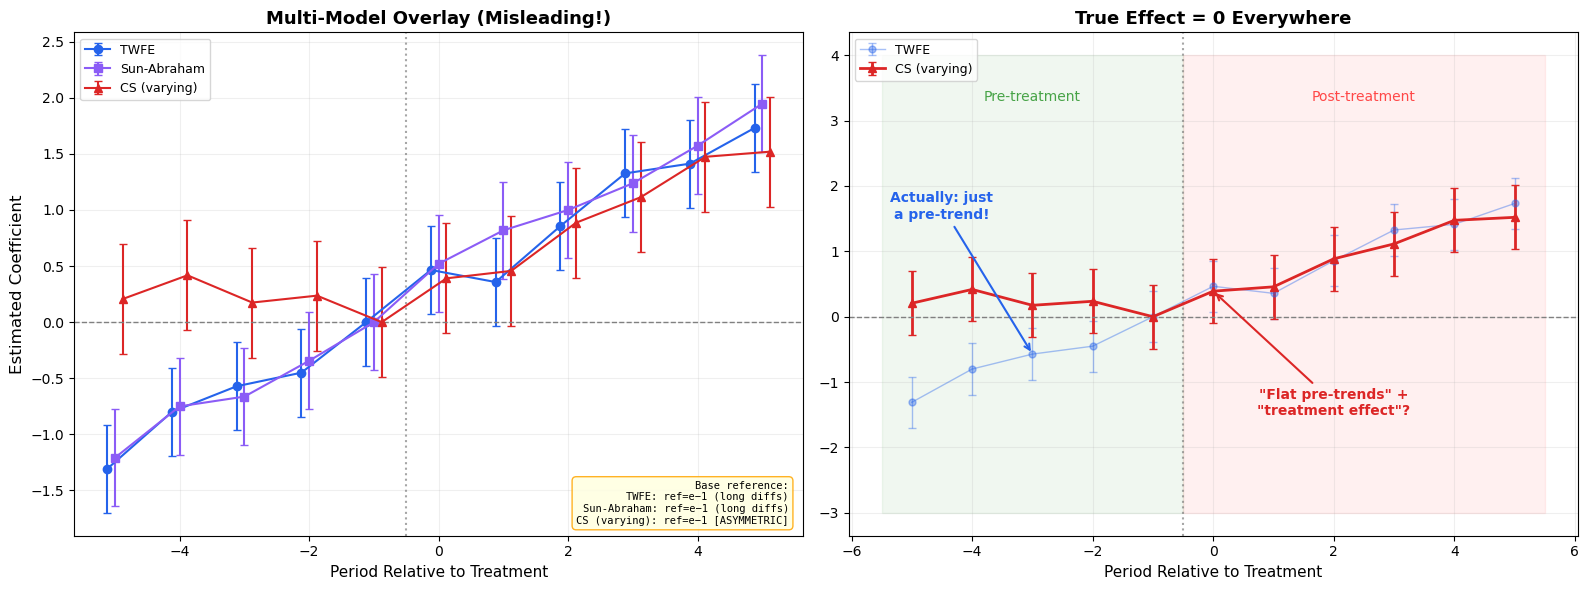

In [5]:
#| label: fig-overlay
#| fig-cap: "Multi-model overlay: CS (varying) produces visually misleading pre-trends when compared against TWFE and Sun-Abraham, both of which correctly show the pre-trend violation."
#| code-fold: true

# Overlay three estimators under a linear pre-trend violation
np.random.seed(123)
periods_overlay = np.arange(-5, 6)
ref = -1
delta = 0.3 * periods_overlay  # linear confound, no treatment

# TWFE: long diffs
twfe = delta - delta[periods_overlay == ref][0] + np.random.normal(0, 0.1, len(periods_overlay))
twfe[periods_overlay == ref] = 0.0
twfe_se = np.full(len(periods_overlay), 0.2)

# Sun-Abraham: long diffs (similar to TWFE, slightly different noise)
sa = delta - delta[periods_overlay == ref][0] + np.random.normal(0, 0.1, len(periods_overlay))
sa[periods_overlay == ref] = 0.0
sa_se = np.full(len(periods_overlay), 0.22)

# CS (varying): short pre, long post
cs_var = np.zeros(len(periods_overlay))
for i, p in enumerate(periods_overlay):
    if p < ref:
        cs_var[i] = 0.3 + np.random.normal(0, 0.1)
    elif p == ref:
        cs_var[i] = 0.0
    else:
        cs_var[i] = 0.3 * (p - ref) + np.random.normal(0, 0.1)
cs_se = np.full(len(periods_overlay), 0.25)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: The misleading overlay
ax = axes[0]
dodge = 0.12
ax.errorbar(periods_overlay - dodge, twfe, yerr=1.96*twfe_se, fmt='o-',
            color='#2563eb', capsize=3, markersize=6, linewidth=1.5, label='TWFE')
ax.errorbar(periods_overlay, sa, yerr=1.96*sa_se, fmt='s-',
            color='#8b5cf6', capsize=3, markersize=6, linewidth=1.5, label='Sun-Abraham')
ax.errorbar(periods_overlay + dodge, cs_var, yerr=1.96*cs_se, fmt='^-',
            color='#dc2626', capsize=3, markersize=6, linewidth=1.5, label='CS (varying)')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_title('Multi-Model Overlay (Misleading!)', fontsize=13, fontweight='bold')
ax.set_xlabel('Period Relative to Treatment', fontsize=11)
ax.set_ylabel('Estimated Coefficient', fontsize=12)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.2)

# Annotation box at bottom-right to avoid legend overlap
ax.text(0.98, 0.02,
        'Base reference:\nTWFE: ref=e\u22121 (long diffs)\nSun-Abraham: ref=e\u22121 (long diffs)\nCS (varying): ref=e\u22121 [ASYMMETRIC]',
        transform=ax.transAxes, fontsize=7.5,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow',
                  edgecolor='orange', alpha=0.85), family='monospace')

# Right: What a reader might wrongly conclude
ax = axes[1]
ax.fill_between([-5.5, -0.5], [-3, -3], [4, 4], alpha=0.06, color='green')
ax.fill_between([-0.5, 5.5], [-3, -3], [4, 4], alpha=0.06, color='red')
ax.text(-3, 3.3, 'Pre-treatment', fontsize=10, color='green', alpha=0.7, ha='center')
ax.text(2.5, 3.3, 'Post-treatment', fontsize=10, color='red', alpha=0.7, ha='center')

ax.errorbar(periods_overlay, twfe, yerr=1.96*twfe_se, fmt='o-',
            color='#2563eb', capsize=3, markersize=5, linewidth=1, alpha=0.4, label='TWFE')
ax.errorbar(periods_overlay, cs_var, yerr=1.96*cs_se, fmt='^-',
            color='#dc2626', capsize=3, markersize=6, linewidth=2, label='CS (varying)')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

ax.annotate('"Flat pre-trends" +\n"treatment effect"?',
            xy=(0, cs_var[periods_overlay == 0][0]), xytext=(2, -1.5),
            fontsize=10, color='#dc2626', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#dc2626', lw=1.5),
            ha='center')
ax.annotate('Actually: just\na pre-trend!',
            xy=(-3, twfe[periods_overlay == -3][0]), xytext=(-4.5, 1.5),
            fontsize=10, color='#2563eb', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#2563eb', lw=1.5),
            ha='center')

ax.set_title('True Effect = 0 Everywhere', fontsize=13, fontweight='bold')
ax.set_xlabel('Period Relative to Treatment', fontsize=11)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Control Group Choice: Never-Treated vs. Not-Yet-Treated {#sec-control-group}

Beyond coefficient construction, there is a second dimension that affects multi-model comparability: **which units serve as controls?**

Callaway-Sant'Anna and Sun-Abraham both offer a `control_group` parameter with two options:

- **`'never_treated'`** (default): Only units that *never* receive treatment serve as controls. This is the most conservative choice — it avoids contamination from units that will later be treated.
- **`'not_yet_treated'`**: Units that haven't been treated *yet* at a given time serve as controls. This uses more data (especially useful when there are few never-treated units) but requires a stronger assumption: that treatment effects don't spill over to future-treated units before they are treated.

## Why This Matters for Multi-Model Comparisons

If you overlay two estimators that use *different* control groups, the estimates may diverge even if everything else is the same — because they are estimating treatment effects relative to **different comparison populations**:

| Estimator A | Estimator B | Comparable? |
|-------------|-------------|-------------|
| CS (`never_treated`) | SA (`never_treated`) | Yes |
| CS (`not_yet_treated`) | SA (`not_yet_treated`) | Yes |
| CS (`never_treated`) | SA (`not_yet_treated`) | **Caution** — different comparison populations |
| Any staggered estimator | Imputation DiD / Two-Stage DiD | **Caution** — BJS always uses all untreated observations (analogous to `not_yet_treated`) |

## When Does the Choice Matter?

The two control groups give similar results when:

- There are many never-treated units (so the `not_yet_treated` pool is dominated by them)
- Treatment effects are homogeneous across cohorts
- There are no anticipation effects

They diverge when:

- **Few never-treated units**: `never_treated` has a small, potentially unrepresentative control pool
- **Heterogeneous effects by cohort**: Future-treated units may have different outcome dynamics than never-treated units
- **Anticipation**: If units respond before formal treatment, `not_yet_treated` controls are contaminated

## Practical Recommendation

When comparing across estimators, **always match the control group**:

```python
# Consistent control group across estimators
cs = CallawaySantAnna(control_group='never_treated')
sa = SunAbraham(control_group='never_treated')

# BJS always uses all untreated obs — note this when comparing
bjs = ImputationDiD()  # no control_group parameter
```

If your results are sensitive to the control group choice, that itself is informative — it suggests treatment effect heterogeneity or anticipation effects that warrant further investigation.

# Conclusions

Event study plots from modern DiD estimators look similar, but the coefficients they produce can mean fundamentally different things. The key takeaways:

1. **Pick the right estimator for your design**. Dynamic TWFE is fine for simultaneous adoption; for staggered designs, Imputation DiD or Two-Stage DiD offer the best efficiency, with CS and SA as robustness checks.

2. **Know whether your estimator uses long or short differences** in the pre-treatment period. This determines what the pre-trend test actually tests — and mixing them on the same plot creates the kink artifact.

3. **The kink artifact is real**: Callaway-Sant'Anna with `base_period='varying'` (the default) creates a visual break at the treatment date that can mimic a treatment effect where none exists.

4. **Match control groups across estimators**. Never-treated vs. not-yet-treated is a substantive choice that affects both the estimand and comparability. When comparing CS/SA with BJS, remember that BJS always uses all untreated observations.

5. **Post-treatment coefficients are generally comparable** across all estimators (they target the same estimand: the ATT at each relative time). **Pre-treatment coefficients require more care** — they may answer different questions depending on the estimator.

As a rule: **before overlaying event studies from different estimators, check that you're comparing like with like** — same coefficient construction, same control group, same reference period.

# References

- Arkhangelsky, D., Athey, S., Hirshberg, D. A., Imbens, G. W., & Wager, S. (2021). Synthetic Difference-in-Differences. *American Economic Review*, 111(12), 4088-4118.
- Borusyak, K., Jaravel, X., & Spiess, J. (2024). Revisiting Event Study Designs: Robust and Efficient Estimation. *Review of Economic Studies*, 91(6), 3253-3285.
- Callaway, B., & Sant'Anna, P. H. C. (2021). Difference-in-Differences with multiple time periods. *Journal of Econometrics*, 225(2), 200-230.
- Gardner, J. (2022). Two-stage differences in differences. *arXiv preprint arXiv:2207.05943*.
- Goodman-Bacon, A. (2021). Difference-in-Differences with Variation in Treatment Timing. *Journal of Econometrics*, 225(2), 254-277.
- Roth, J. (2026). Interpreting Event Studies from Recent Difference-in-Differences Methods. *arXiv preprint arXiv:2401.12309*.
- Sun, L., & Abraham, S. (2021). Estimating Dynamic Treatment Effects in Event Studies with Heterogeneous Treatment Effects. *Journal of Econometrics*, 225(2), 175-199.
- Gerber, I. (2025). diff-diff: A comprehensive Python package for Difference-in-Differences. [GitHub](https://github.com/igerber/diff-diff).